In [1]:
import scanpy as sc
import glob

In [2]:
import os
os.chdir('/mnt/data3/wangj2/MouseKidney/')

In [3]:
import anndata2ri
from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
anndata2ri.activate()

/tmp/ipykernel_63806/3569427243.py:4: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
r('library(Seurat)')
r(f'x<-load("Stromal.RData")')
r('y=get(x)')
r('rm(x)')
r('DefaultAssay(y) <- "RNA"') 
adata = r('as.SingleCellExperiment(y)')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject



In [ ]:
### plot sc data
import seaborn as sns 
plot = sns.violinplot(x="celltype_L2", 
               y="ECM_UCell", 
               hue="Condition",
               data=adata.obs,       
               split=True,
               scale='width',
               cut=0.25,
               palette = {'WT' : "#36BCCB",'KO': "#FF745A"})
plot.legend(loc='upper left')
plot.get_figure().savefig('ECM_UCell.png',dpi = 300) 

In [5]:
adata.obsm['X_umap'] = r('Embeddings(y,reduction = "umap")')
adata.obsm['X_pca'] = r('Embeddings(y,reduction = "pca")')
adata

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



AnnData object with n_obs × n_vars = 1084 × 19127
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Condition', 'cellnames', 'pANN_0.25_0.12_561', 'Doublets', 'pANN_0.25_0.13_544', 'pANN_0.25_0.03_678', 'pANN_0.25_0.01_468', 'pANN_0.25_0.01_514', 'pANN_0.25_0.3_667', 'project', 'integrated_snn_res.0.8', 'seurat_clusters', 'celltype_L2', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'ident'
    obsm: 'X_umap', 'SCVI', 'X_pca'
    layers: 'logcounts'

In [6]:
# RNA-velocity
import scvelo as scv

In [7]:
ldata_raw = scv.read("/mnt/data3/wangj2/MouseKidney/Velo/merged.loom")
ldata_raw

AnnData object with n_obs × n_vars = 56831 × 31053
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [8]:
ldata  = ldata_raw.copy()

In [9]:
### uniform cell ID
cellID = ldata.obs_names.values
cellnames = [s.split(":")[1].replace("x","-1") for s in cellID]
batch = [s.split(":")[0] for s in cellID]
import pandas as pd
batch = pd.DataFrame(pd.Categorical(batch),columns=['batch'])
batch['batch']
batch['batch'].cat.categories = ['_4','_5','_6','_1','_2','_3']
cellID = []
for i,j in zip(cellnames,list(batch['batch'])):
    cellID.append(i+j)
ldata.obs_names = cellID
ldata = ldata[[id in adata.obs_names for id in cellID]]
ldata 

View of AnnData object with n_obs × n_vars = 1084 × 31053
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [10]:
# velocyto matrix
# ldata.obs['celltype_L1'] = adata[ldata.obs_names,:].obs['celltype_L1']
# ldata.obs['celltype_L2'] = adata[ldata.obs_names,:].obs['celltype_L2']
# ldata.obs['Condition'] = adata[ldata.obs_names,:].obs['Condition']
# ldata.obs['ECM_UCell'] = adata[ldata.obs_names,:].obs['ECM_UCell']
# ldata.obs['Senescence_UCell'] = adata[ldata.obs_names,:].obs['Senescence_UCell']
ldata.obs['Cluster'] = adata[ldata.obs_names,:].obs['seurat_clusters']
ldata.obs['batch'] = adata[ldata.obs_names,:].obs['orig.ident']
Sdata = ldata.copy()

In [12]:
Group = []
for i in range(0,Sdata.shape[0]):
    Group.append(Sdata.obs['celltype_L2'][i] +'_' + Sdata.obs['Condition'][i])
Sdata.obs['Group'] = pd.Categorical(Group)

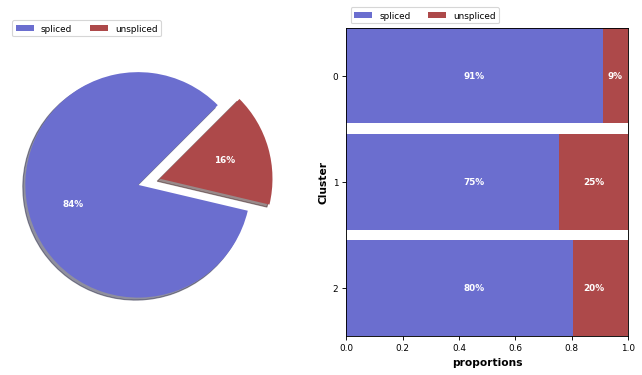

In [13]:
scv.pl.proportions(Sdata,groupby='Cluster',dpi=80,figsize = (10,5))

In [ ]:
# Sdata.write_h5ad("scVelo.h5ad")

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:02) --> added 
    'stochastic', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


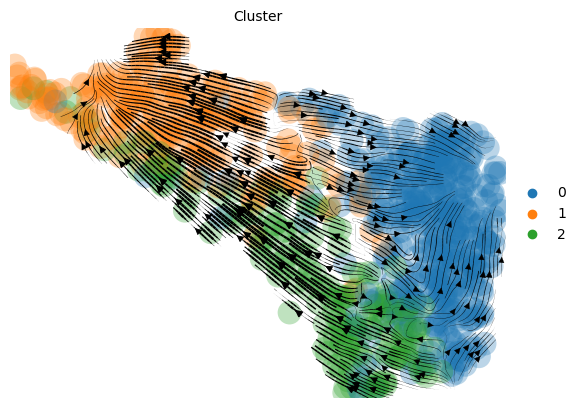

In [36]:
### calculate velocity graph
import numpy as np
# SSdata = Sdata[(Sdata.obs['celltype_L1']=='Stroma')&(Sdata.obs['Condition'] == 'KO')]
# SSdata = Sdata[(Sdata.obs['celltype_L1'] == 'Stroma')]
SSdata = Sdata.copy()
SSdata = SSdata[SSdata.obs['batch'].isin(['KO1','KO2','KO3'])]
SSdata.var_names_make_unique()
# scv.pp.filter_and_normalize(SSdata,n_top_genes=2000,retain_genes=['Thbs2', 'Col4a4', 'Tnr', 'Col6a6', 'Vwf', 'Gp6', 'Col1a2', 'Itga3', 'Itga9', 'Col4a5', 'Gp5', 'Lamc1', 'Itga6', 'Itga1', 'Itgb5', 'Itgb8', 'Sv2c', 'Thbs3', 'Hmmr', 'Cd44', 'Lama3', 'Lamb1', 'Lamb3', 'Col6a4', 'Lama4', 'Itgb4', 'Lamc3', 'Itgb7', 'Col1a1', 'Fn1', 'Vtn', 'Sv2a', 'Col9a2', 'Itgb3', 'Gp1bb', 'Col9a3', 'Hspg2', 'Npnt', 'Gp1ba', 'Col9a1', 'Itga5', 'Itgav', 'Lama2', 'Col2a1', 'Spp1', 'Sdc4', 'Tnxb', 'Itga10', 'Col4a3', 'Sdc1', 'Lama5', 'Sv2b', 'Col6a3', 'Reln', 'Itga7', 'Itga2', 'Lamc2', 'Col6a2', 'Ibsp', 'Col4a6', 'Comp', 'Col6a1', 'Tnn', 'Itga11', 'Itgb6', 'Lamb2', 'Chad', 'Thbs4', 'Gp9', 'Itga8', 'Dag1', 'Itga2b', 'Agrn', 'Col4a2', 'Col4a1', 'Cd36', 'Lama1', 'Col6a5', 'Itgb1', 'Itga4', 'Thbs1', 'Tnc', 'Cd47'
# ])
# scv.pp.filter_and_normalize(SSdata)
npcs = 30
nn = 50
scv.pp.moments(SSdata,use_rep = 'X_pca',n_pcs = npcs,n_neighbors=nn)
# sc.external.pp.bbknn(SSdata, batch_key='batch') 
scv.pp.neighbors(SSdata, n_pcs=npcs, n_neighbors=nn)
sc.tl.louvain(SSdata,resolution= 0.5)
sc.tl.umap(SSdata,n_components=npcs)
scv.tl.velocity(SSdata,'stochastic')
scv.tl.velocity_graph(SSdata)
scv.pl.velocity_embedding_stream(SSdata,basis = "umap",color='Cluster',density = 4,dpi=100,legend_loc="upper_right")

In [ ]:
scv.tl.score_genes_cell_cycle(SSdata)
scv.pl.scatter(SSdata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

In [ ]:
sc.pl.umap(SSdata,color=['batch','celltype_L2','Condition'],palette={'KO1':'#D13808','KO2':'#FF6836','KO3':'#FFC5AC',
                                                                     'WT1':'#227BA2','WT2':'#22BAED','WT3':'#ABDFFF',
                                                                     'Fibro':'#1AAF8B','Myofib':'#36BCCB','Per':'#F6BD16',
                                                                     'WT':"#36BCCB",'KO':"#FF745A"})
sc.pl.umap(SSdata,color=['louvain','ECM_UCell','Senescence_UCell'])

In [ ]:
scv.tl.velocity_confidence(SSdata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(SSdata, c=keys, cmap='coolwarm', perc=[5, 95])

In [ ]:
scv.pl.velocity_graph(SSdata, threshold=.1)

In [ ]:
x, y = scv.utils.get_cell_transitions(SSdata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(SSdata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(SSdata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

In [ ]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

In [ ]:
### predict trajectory by paga
sc.tl.paga(SSdata, groups='louvain', use_rna_velocity = True)

In [ ]:
sc.pl.paga(SSdata) 

In [ ]:
sc.tl.umap(SSdata, init_pos='paga')
sc.pl.umap(SSdata,color='celltype_L2')

In [ ]:
### show cluster top DEGs
scv.tl.rank_velocity_genes(SSdata, groupby='louvain', min_corr=.3)
df = scv.DataFrame(SSdata.uns['rank_velocity_genes']['names'])
scv.pl.scatter(SSdata, df['1'][:5])